# Digitize image of SSC covariance

Reference: Barreira, Krause & Schmidt, http://arxiv.org/abs/1711.07467

In [1]:
from platform import python_version
print(python_version())

3.6.8


In [2]:
# Note for Mac Book Pro: cv2 installed in shapepipe conda env, path is somehow
# not loaded automatically.
import os, sys
sys.path.insert(0, '/Users/mkilbing/anaconda3/envs/shapepipe/lib/python3.6/site-packages')
os.sys.path

['/Users/mkilbing/anaconda3/envs/shapepipe/lib/python3.6/site-packages',
 '',
 '/Users/mkilbing/anaconda3/lib/python36.zip',
 '/Users/mkilbing/anaconda3/lib/python3.6',
 '/Users/mkilbing/anaconda3/lib/python3.6/lib-dynload',
 '/Users/mkilbing/.local/lib/python3.6/site-packages',
 '/Users/mkilbing/.local/lib/python3.6/site-packages/shapepipe-0.0.1-py3.6.egg',
 '/Users/mkilbing/anaconda3/lib/python3.6/site-packages',
 '/Users/mkilbing/anaconda3/lib/python3.6/site-packages/aeosa',
 '/Users/mkilbing/anaconda3/lib/python3.6/site-packages/shapepipe-0.0.1-py3.6.egg',
 '/Users/mkilbing/anaconda3/lib/python3.6/site-packages/sf_tools-2.0.0-py3.6.egg',
 '/Users/mkilbing/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/mkilbing/.ipython']

In [3]:
# cv2 module: pip install opencv-python
import cv2
from scipy import interpolate
import pylab as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

In [4]:
dat = cv2.imread('fig_cov_l1l2_maps.png', -1)

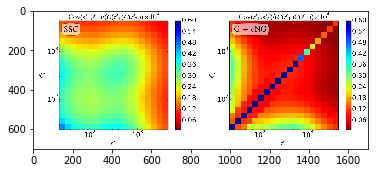

In [5]:
ax = plt.imshow(dat)

Cut out left panel, SSC covariance

In [6]:
lower_x = 139
lower_y =  55
upper_x = 679
upper_y = 595

In [7]:
cov_fine = dat[lower_y : upper_y, lower_x : upper_x]

Invert x-axis such that lower left image corner is (0,0).

In [8]:
cov_fine = cov_fine[::-1,:,:]

Plot with new axis direction accounted for, origin at lower left corner

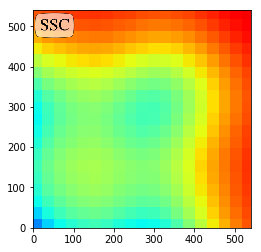

In [9]:
ax = plt.imshow(cov_fine, cmap=cm.jet, origin='lower')

In [10]:
import scipy.cluster.vq as scv
def colormap2arr(arr,cmap,N=100):    
    # http://stackoverflow.com/questions/3720840/how-to-reverse-color-map-image-to-scalar-values/3722674#3722674
    gradient=cmap(np.linspace(0.0, 1.0, N)) #[:, 0:3]

    # Reshape arr to something like (240*240, 4), all the 4-tuples in a long list...
    arr2=arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2]))

    # Use vector quantization to shift the values in arr2 to the nearest point in
    # the code book (gradient).
    code,dist=scv.vq(arr2,gradient)

    # code is an array of length arr2 (240*240), holding the code book index for
    # each observation. (arr2 are the "observations".)
    # Scale the values so they are from 0 to 1.
    values=code.astype('float')/gradient.shape[0]

    # Reshape values back to (240,240)
    values=values.reshape(arr.shape[0],arr.shape[1])
    values=values[::-1, ::-1]
    return values

Transform RGB tuple to scalar

In [11]:
cov_sc = colormap2arr(cov_fine, cm.jet, N=300)
#cov_sc = cov_fine

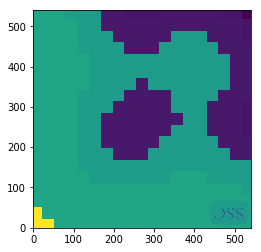

In [12]:
ax = plt.imshow(cov_sc, origin='lower')

Remap to original image pixels in $\ell$.

In [13]:
npix = 19
n = upper_x - lower_x
step = int(n / npix)
cov = cov_sc[0:n:step,0:n:step]

Copy upper left to lower right triangle, to overwrite plot legend

In [14]:
i_upper = np.triu_indices(npix+1, -1)
cov[i_upper] = cov.T[i_upper]

Last pixel is mapped to wrong value, change it by hand

In [15]:
cov[npix, npix] = cov[npix-1, npix-1]

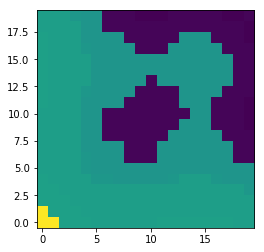

In [16]:
ax = plt.imshow(cov, interpolation='none', origin='lower')

Cut out color legend from image

In [17]:
x_leg = 730
lower_y_leg = 54 + 10
upper_y_leg = 590 - 10
n_leg = upper_y_leg - lower_y_leg

In [18]:
leg_fine = dat[lower_y_leg : upper_y_leg, (x_leg-1):(x_leg+1)]

In [19]:
leg_sc = colormap2arr(leg_fine, cm.jet, N=50)
#leg_sc = leg_fine

In [20]:
step = 70
leg = leg_sc[0:n_leg:step, :]
leg = leg[::-1,:]

array([0.12, 0.34, 0.36, 0.38, 0.62, 0.64, 0.66, 0.86])

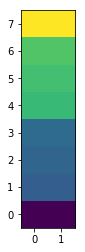

In [21]:
plt.imshow(leg, origin='lower')
leg0 = leg[:,0]
leg0

Map colors to values according to legend labels, and create interpolation object

In [22]:
v0 = 0
v1 = 0.6
v = np.linspace(v0, v1, len(leg0))
leg_interp = interpolate.interp1d(leg0, v, kind='linear', bounds_error=False, fill_value=0)

In [23]:
my_v = leg_interp(0.8)

Text(0.5, 0, 'leg')

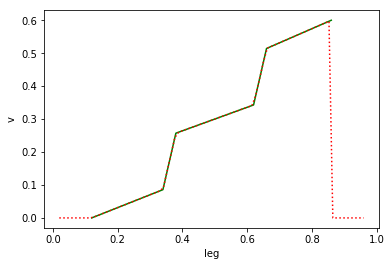

In [24]:
plt.plot(leg0, v, 'g-')
leg0_10 = np.linspace(leg0[0]-0.1, leg0[-1]+0.1, len(leg0)*10)
plt.plot(leg0_10, leg_interp(leg0_10), 'r:')
plt.ylabel('v')
plt.xlabel('leg')

Crop values that are outside legend range

In [25]:
cov[cov > leg0.max()] = leg0.max()

Create matrix with real (covariance) values according

In [26]:
cov_v = []
for i in range(cov.shape[0]):
    row = leg_interp(cov[:,i])
    cov_v.append(row)
cov_v = np.array(cov_v)

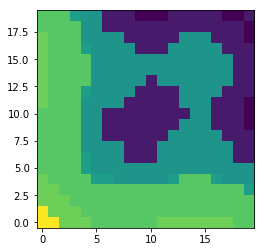

In [27]:
ax = plt.imshow(cov_v, interpolation='none', origin='lower')

In [28]:
x1, x2 = np.mgrid[0:npix+1:1, 0:npix+1:1]
grid   = np.dstack((x1, x2))

$\ell$-values (logarithmic = original bins)

In [29]:
lmin = 25
lmax = 4000
log_lmin = np.log10(lmin)
log_lmax = np.log10(lmax)
log_l = np.linspace(log_lmin, log_lmax, npix+1)

In [30]:
print(log_lmin, log_lmax)

1.3979400086720377 3.6020599913279625


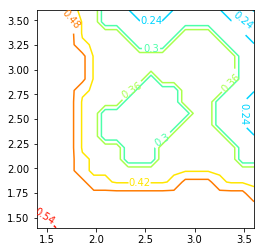

In [31]:
fig, ax = plt.subplots()
CS = ax.contour(log_l, log_l, cov_v, levels=[0.06, 0.12, 0.18, 0.24, 0.3, 0.36, 0.42, 0.48, 0.54, 0.6], cmap=cm.jet, origin='lower')
CS.levels = [val for val in CS.levels]
txt = ax.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax.set_aspect('equal')

Write matrix to file, and create 1D arrays forming a grid (ell_x, ell_y) for later interpolation to linear bins.

In [32]:
f = open('cov_SSC_rel_log.txt', 'w')
ell_x = []
ell_y = []
for i in range(npix+1):
    y = 10**log_l[i]
    for j in range(npix+1):
        x = 10**log_l[j]
        print('{:8.2f} {:8.2f} {:.3f}'.format(y, x, cov[i][j]), file=f)
        ell_x.append(x)
        ell_y.append(y)
f.close()

$\ell$-values (linear: interpolate from logarithmic bins)

In [36]:
n_ell = 30 # npix+1
cov_v_func = interpolate.interp2d(ell_x, ell_y, cov_v, kind='linear')
ell = np.linspace(lmin, lmax, n_ell)
cov_v_lin = cov_v_func(ell, ell)

# Somehow the matrix is not symmetric: Symmetrize
cov_v_lin_sym = 0.5 * (cov_v_lin + cov_v_lin.transpose())


# Same for real cov values
cov_func = interpolate.interp2d(ell_x, ell_y, cov, kind='linear')
cov_lin = cov_func(ell, ell)

# Somehow the matrix is not symmetric: Symmetrize
cov_lin_sym = 0.5 * (cov_lin + cov_lin.transpose())

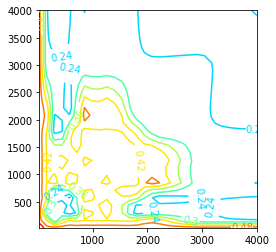

In [37]:
fig, ax = plt.subplots()
CS = ax.contour(ell, ell, cov_v_lin_sym, levels=[0.06, 0.12, 0.18, 0.24, 0.3, 0.36, 0.42, 0.48, 0.54, 0.6], cmap=cm.jet, origin='lower')
CS.levels = [val for val in CS.levels]
txt = ax.clabel(CS, CS.levels, inline=True, fmt='%r', fontsize=10)
ax.set_aspect('equal')

Writing matrix for linear bins

In [38]:
f = open('cov_SSC_rel_lin.txt', 'w')
for i in range(n_ell):
    y = ell[i]
    for j in range(n_ell):
        x = ell[j]
        print('{:8.2f} {:8.2f} {:.3f}'.format(y, x, cov_lin_sym[i][j]), file=f)
f.close()

Testing: reading cov file

In [36]:
from astropy.io import ascii
dat = ascii.read('cov_SSC_rel_log.txt')

In [37]:
n = int(np.sqrt(len(dat)))

In [38]:
drel = (10**log_l - dat['col2'][0:n])/dat['col2'][0:n]

In [39]:
if np.where(drel > 1e-3)[0].any():
    print('Diff')

Read covariance matrixes from ABC run and plot

In [42]:
cov_G = np.loadtxt('cov_G.txt')
cov_SSC = np.loadtxt('cov_SSC.txt')
cov_est = np.loadtxt('cov_est.txt')
vmax = max(cov_G.max(), cov_SSC.max(), cov_est.max())

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
img1 = ax1.imshow(cov_G, origin='lower', interpolation='none', vmin=0, vmax=vmax)
img2 = ax2.imshow(cov_SSC, origin='lower', interpolation='none', vmin=0, vmax=vmax)
img3 = ax3.imshow(cov_G + cov_SSC, origin='lower', interpolation='none', vmin=0, vmax=vmax)
img4 = ax4.imshow(cov_est, origin='lower', interpolation='none', vmin=0, vmax=vmax)
plt.colorbar(img1)

Plot correlation coefficients

In [ ]:
from mkstuff import corr_coeff

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
img1 = ax1.imshow(corr_coeff(cov_SSC), origin='lower', interpolation='none', vmin=0, vmax=1)
img2 = ax2.imshow(corr_coeff(cov_G + cov_SSC), origin='lower', interpolation='none', vmin=0, vmax=1)
img3 = ax3.imshow(corr_coeff(cov_est), origin='lower', interpolation='none', vmin=0, vmax=1)
plt.colorbar(img1)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
vmax = max((cov_G/cov_SSC).max(), ((cov_G+cov_SSC)/cov_SSC).max(), (cov_est/cov_SSC).max())
img1 = ax1.imshow(cov_G/cov_SSC, origin='lower', interpolation='none', vmin=0, vmax=vmax)
img2 = ax2.imshow((cov_G+cov_SSC)/cov_SSC, origin='lower', interpolation='none', vmin=0, vmax=vmax)
img3 = ax3.imshow(cov_est/cov_SSC, origin='lower', interpolation='none', vmin=0, vmax=vmax)
plt.colorbar(img1)

Plot ratio of SSC to (G+SSC) covariance. This can be compared to Fig. 5c of BKS17.
Note however that the latter is normalised to the total covariance including the cNG term.

In [ ]:
dat = cv2.imread('BKS17_Fig5ac.png')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.semilogx(10**log_l, np.diag(cov_SSC) / np.diag(cov_G + cov_SSC))
xlab = ax1.set_xlabel('$\ell$')
ylab = ax1.set_ylabel('SSC / (G + SSC)')

ax2.imshow(dat)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

Plot diagonal of SSC cov, in linear and log ell.

In [ ]:
dat_log = ascii.read('cov_SSC_rel_log.txt')
dat_lin = ascii.read('cov_SSC_rel_lin.txt')

In [ ]:
w = dat_log['col1'] == dat_log['col2']
plt.plot(dat_log['col1'][w], dat_log['col3'][w])

w = dat_lin['col1'] == dat_lin['col2']
plt.plot(dat_lin['col1'][w], dat_lin['col3'][w])
dat_lin['col3'][w]